In [ ]:
# TBD: create bash script
# To download kssl dataset
# pip install gdown install --upgrade --no-cache-dir gdown

# cd /root
# python
# import gdown
# Links: 
#   - VNIR LUCAS: "1OnwGgDqvjnDYEik14h_lSi83M4AwzYBt"
#   - VNIR KSSL: "17ZNSqsQi6PUeOLnUozq-C6Pj22dItm_Y"
# id = "1qh8isMQIzhArsj3RNWJe6g0lx_cs7iBG" # MIRS KSSL v1 or "1SzQZqpbJuK3iCqjJYabuEobbgPXm3cHT" for v2
# gdown.download(id=id)
# quit()
# tar -xvf kssl.tar.gz

# paperspace only
#!pip install gdown 
#!pip install --upgrade gdown

In [ ]:
!pip install spanda

^C
ERROR: Operation cancelled by user


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from pathlib import Path
from datetime import datetime

from fastai.vision.all import *
from fastai.data.all import *
from tqdm import tqdm
import timm
from sklearn.metrics import (r2_score, mean_squared_error, mean_absolute_error)


from spanda.data.transforms import (SpectraBlock, AnalytesBlock, Analytes, SpectraTfm, 
                                    TrimTfm, AnalytesTfm, SNVTfm, RandWAvgTfm, AvgTfm, GADFTfm, 
                                    To3DTfm, ResizeTfm, LogTfm)

use_cuda = torch.cuda.is_available()
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'


import warnings
warnings.filterwarnings('ignore')

## Utilities

In [ ]:
get_spectra = lambda o: L(f for f in o.ls() if not re.match('target', f.name))
get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

In [ ]:
def get_paths(src_dir, analytes=['725']):     
    path = Path(src_dir)
    
    # Only samples with spectra
    paths = [p for p in tqdm(path.ls()) if len(p.ls()) > 1]
    
    # Only strictly positive measurements
    paths = [p for p in tqdm(paths) if AnalytesTfm(analytes=analytes)(get_target(p)) > 0] 
    
    return L(paths)

In [ ]:
def get_dls(paths, analytes=['725'], seed=42):
    get_spectra = lambda o: L(f for f in o.ls() if not re.match('target', f.name))
    get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

    dblock = DataBlock(blocks=(SpectraBlock, AnalytesBlock(analytes=analytes)),
                       get_x=get_spectra,
                       get_y=get_target,
                       splitter=RandomSplitter(valid_pct=0.2, seed=seed),
                       item_tfms=[AvgTfm(), SNVTfm(),
                                  LogTfm])
    return dblock.dataloaders(paths, bs=32, num_workers=6)

In [ ]:
current_date = lambda: datetime.now().date().isoformat()

## Data loading

In [ ]:
analytes = ['725'] # Kex

In [ ]:
paths_kssl = get_paths('../../_data/kssl-vnir', analytes=analytes)
#paths_kssl = get_paths('kssl-vnir', analytes=analytes)

100%|████████████████████████████████████████████████████████| 20949/20949 [00:15<00:00, 1337.48it/s]


In [ ]:
paths_lucas = get_paths('../../_data/lucas-vnir', analytes=analytes)
#paths_lucas = get_paths('lucas-vnir', analytes=analytes)

100%|████████████████████████████████████████████████████████| 21782/21782 [00:16<00:00, 1333.81it/s]


In [ ]:
paths_all = paths_kssl + paths_lucas; paths_all

(#42728) [Path('../../_data/kssl-vnir/163161'),Path('../../_data/kssl-vnir/110493'),Path('../../_data/kssl-vnir/97322'),Path('../../_data/kssl-vnir/166413'),Path('../../_data/kssl-vnir/92650'),Path('../../_data/kssl-vnir/47957'),Path('../../_data/kssl-vnir/170576'),Path('../../_data/kssl-vnir/120206'),Path('../../_data/kssl-vnir/42419'),Path('../../_data/kssl-vnir/78584')...]

## Train & evaluate

### Train KSSL

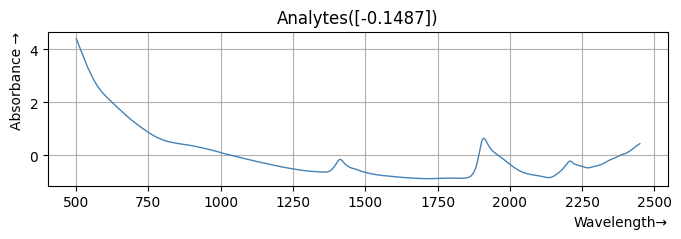

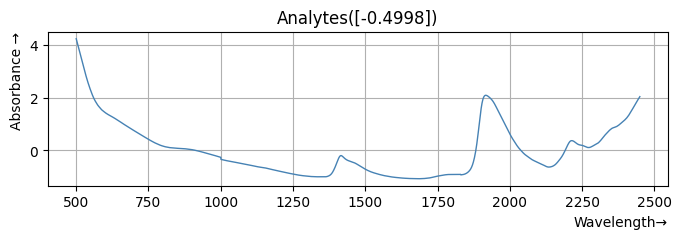

In [ ]:
dls = get_dls(paths_kssl)
dls.show_batch(max_n=2)

In [ ]:
# Create Learner
model = xresnet18(ndim=1, c_in=1, ks=3, n_out=1).to(device)
learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=R2Score())

SuggestedLRs(valley=0.001737800776027143)

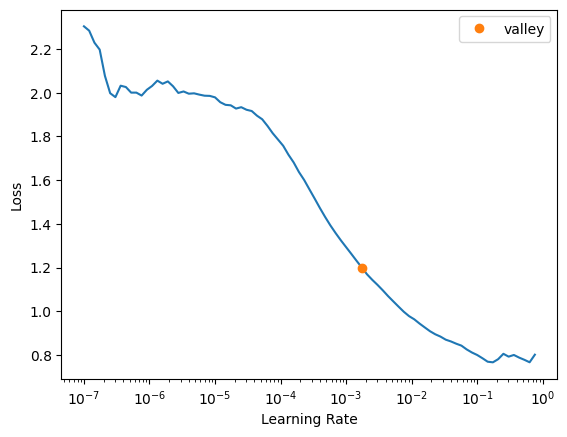

In [ ]:
learn.lr_find()

In [ ]:
# params
ds_name = 'kssl'
lr = 2e-3
epochs = 20

In [ ]:
# to do
# fit
# save model
# evaluate load model
# save metrics
learn.fit_one_cycle(20, 1e-3)

epoch,train_loss,valid_loss,r2_score,time
0,0.198279,0.371190,-0.526396,00:26
1,0.196384,0.225860,0.071226,00:27
2,0.192651,0.225498,0.072715,00:35
3,0.185206,0.198236,0.184819,00:47
4,0.184945,0.160787,0.338818,00:26
5,0.154341,0.798050,-2.281719,00:44
6,0.132587,0.151428,0.377301,00:36
7,0.119772,0.297940,-0.225180,00:26
8,0.110601,0.105004,0.568204,00:51
9,0.102634,0.147760,0.392387,00:26


#### Eval on KSSL

In [ ]:
preds_kssl, targs_kssl = learn.get_preds(ds_idx=1)

In [ ]:
model_name = f'xresnet18-kex-nirs-{ds_name}-{epochs}-epochs-lr-{lr:.1e}-r2-{r2_score(targs_kssl, preds_kssl):.2}-{current_date()}'

In [ ]:
learn.save(model_name)

Path('models/xresnet18-kex-nirs-kssl-20-epochs-lr-2.0e-03-r2-0.69-2023-06-12.pth')

In [ ]:
dls_lucas = get_dls(paths_lucas)

In [ ]:
preds_lucas, targs_lucas = learn.get_preds(dl=dls_lucas.valid)

#### Eval on LUCAS

In [ ]:
# Eval on 
r2_score(targs_lucas, preds_lucas)

-0.2357146436679538

#### Finetune LUCAS on KSSL

In [ ]:
dls_lucas = get_dls(paths_lucas)

In [ ]:
# Pre-trained model (KSSL)
model = xresnet18(ndim=1, c_in=1, ks=3, n_out=1).to(device)
learn = Learner(dls_lucas, model, loss_func=MSELossFlat(), metrics=R2Score())

weights_paths = '../../_data/models/xresnet18-kex-nirs-kssl-20-epochs-lr-2.0e-03-r2-0.69-2023-06-12.pth'
#weights_paths = 'models/xresnet18-kex-nirs-kssl-20-epochs-lr-2.0e-03-r2-0.69-2023-06-12.pth.pth'
xresnet_dict = torch.load(weights_paths, map_location=torch.device('cpu')) 
model.load_state_dict(xresnet_dict['model'])

<All keys matched successfully>

In [ ]:
for layer in flatten_model(learn):
    if isinstance(layer, nn.Linear) or isinstance(layer, nn.BatchNorm1d):
        for param in layer.parameters():
            param.requires_grad = True
    else:
        for param in layer.parameters():
            param.requires_grad = False      

In [ ]:
#learn.summary()

XResNet (Input shape: 32 x 1 x 1951)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 32 x 976       
Conv1d                                    96         False     
BatchNorm1d                               64         True      
ReLU                                                           
Conv1d                                    3072       False     
BatchNorm1d                               64         True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 976       
Conv1d                                    6144       False     
BatchNorm1d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 488       
MaxPool1d                                  

In [ ]:
learn.lr_find()

KeyboardInterrupt: 

In [ ]:
learn.fit_one_cycle(3, 3e-4)

epoch,train_loss,valid_loss,r2_score,time


KeyboardInterrupt: 